In [1]:
import matplotlib.gridspec 
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import scipy.io
import sys
import os

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.style import MPL_STYLES, BLUE_BLACK, BLUE_DARK, BLUE
from dn_utils.plotting import hex_to_rgb, barplot_annotate
from dn_utils.behavioral_models import load_behavioral_data, calculate_reversals

%matplotlib inline

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/dn_utils/glm_utils.py:13: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats import design_matrix


In [2]:
path_out = os.path.join(
    path_root, 
    'data/main_fmri_study/derivatives/jags')
path_hlm_sequential = os.path.join(
    path_out, 
    'jags_output/HLM_sequential_split.mat')
path_hlm_sequential_pep = os.path.join(
    path_out, 
    'vba/pep_HLM_sequential_split.mat')
path_h_pdci = os.path.join(
    path_out, 
    'jags_output/H_pdci.mat')
path_alpha_pdci_mle_3digits = os.path.join(
    path_out, 
    'parameter_estimates/alpha_pdci_mle_3digits.npy')
path_beta_pdci_mle_3digits = os.path.join(
    path_out, 
    'parameter_estimates/beta_pdci_mle_3digits.npy')
path_figures = os.path.join(path_out, 'figures')

# Load behavioral variables
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]
n_models = 4
n_prederrsign = 2

# Define subject and model labels
sublabels = [f'm{sub:02}' for sub in range(2, n_subjects+2)]
modelnames = ['PICI', 'PICD', 'PDCI', 'PDCD']

# Load posterior samples (HLM model)
mat = scipy.io.loadmat(
    path_hlm_sequential, 
    variable_names=['samples'], 
    squeeze_me=True)
z = mat['samples']['z'].item()
n_samples_hlm_sequential = z.shape[0] * z.shape[1]

# Calculate posterior model probabilities
pmp = np.concatenate(
    tuple(np.sum((z == i) + (z == i + n_models) + (z == i + 2 * n_models), 
                 axis=(0, 1))[np.newaxis, :] 
          for i in range(1, 5)), 
    axis=0)
pmp = pmp / n_samples_hlm_sequential

# Load posterior exceedance probabilities (model is most frequent)
pep = scipy.io.loadmat(path_hlm_sequential_pep, squeeze_me=True)['pep']

# Load parameter estimates (MLE) for PDCI model
alpha_pdci_mle = np.load(path_alpha_pdci_mle_3digits)
beta_pdci_mle = np.load(path_beta_pdci_mle_3digits)

# Load posterior samples for hierarchical model with PDCI submodel
mat = scipy.io.loadmat(
    path_h_pdci, 
    variable_names=['samples', 'nSamples', 'nChains'], 
    squeeze_me=True)
samples = mat['samples']

n_samples_h_pdci = mat['nSamples']
n_chains_h_pdci = mat['nChains']

# Load samples for relevant behavioral parameters
alpha_pdci = samples['alpha_pdci'].item()
beta_pdci = samples['beta_pdci'].item()
alpha_pdci = np.reshape(
    alpha_pdci, 
    (n_chains_h_pdci * n_samples_h_pdci, n_subjects, n_prederrsign))
beta_pdci = np.reshape(
    beta_pdci, 
    (n_chains_h_pdci * n_samples_h_pdci, n_subjects))

# Posterior model probabilities for model families
pmp_models = np.sum(pmp, axis=1) / n_subjects
pmp_pd_vs_pi = [
    pmp_models[modelnames.index('PDCI')] + pmp_models[modelnames.index('PDCD')],
    pmp_models[modelnames.index('PICI')] + pmp_models[modelnames.index('PICD')],
]
pmp_cd_vs_ci = [
    pmp_models[modelnames.index('PICD')] + pmp_models[modelnames.index('PDCD')],
    pmp_models[modelnames.index('PICI')] + pmp_models[modelnames.index('PDCI')],
]

# Number of reversals
reversals = np.zeros((n_subjects, n_conditions))
for i in range(n_subjects):
    for j in range(n_conditions):
        reversals[i, j] = calculate_reversals(
            beh[i, j, :, meta['dim4'].index('response')])

In [3]:
mpl.rcParams.update(MPL_STYLES)

# dominant color
COLOR = BLUE

# colormap
CMAP = mcolors.LinearSegmentedColormap.from_list(
    "custom", 
    [(1, 1, 1), hex_to_rgb(COLOR)], 
    N=30)

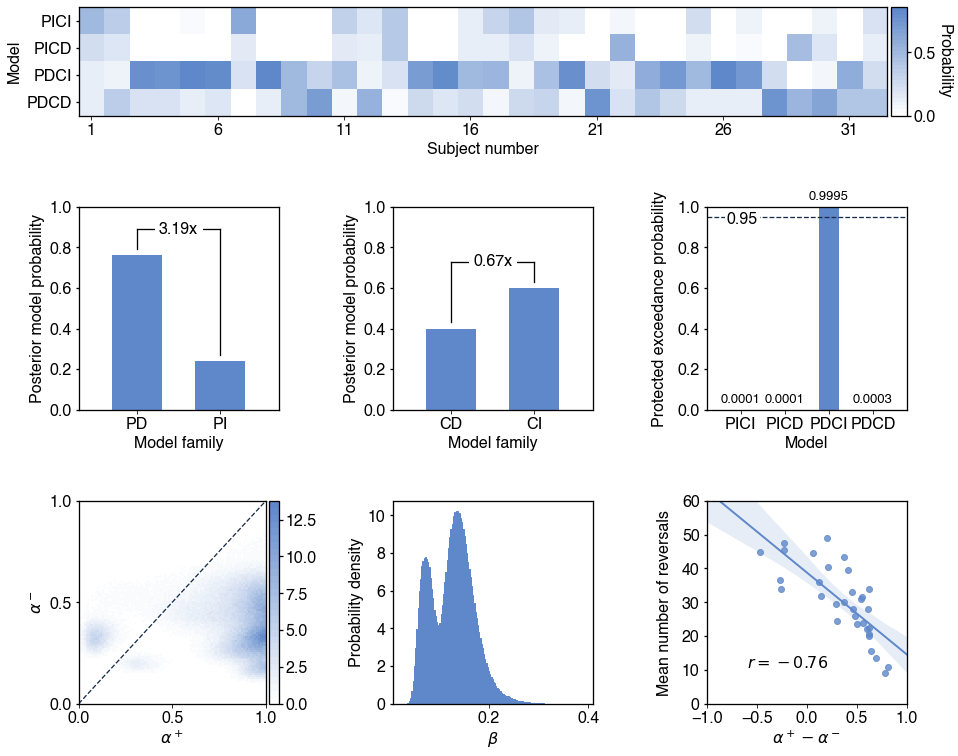

In [4]:
fig = plt.figure(figsize=(14, 12.5), facecolor='w')
gs = matplotlib.gridspec.GridSpec(3, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[2, 2])
axs = (ax1, ax2, ax3, ax4, ax5, ax6, ax7)

############
### AX 1 ### 
############
xtick_range_args = (0, n_subjects, 5)
xtick_sub_numbers = (1, n_subjects, 5)

im = ax1.imshow(pmp, aspect='auto', cmap=CMAP)

ax1.set_xticks(range(*xtick_range_args))
ax1.set_xticklabels(range(*xtick_sub_numbers))
ax1.set_xlabel('Subject number')
ax1.set_yticks(range(n_models))
ax1.set_yticklabels(modelnames)
ax1.set_ylabel('Model')

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="2%", pad=0.05)
cbar1 = plt.colorbar(im, cax=cax1)
cbar1.ax.get_yaxis().labelpad = 15
cbar1.ax.set_ylabel('Probability', rotation=270)

############
### AX 2 ###
############
offset_bar = 0.03 
offset_top = 0.1
bar_xlim = (0, 1)
bar_ylim = (0, 1)
bar_width = 0.25
bar_width_four = 0.1
bar_xticks = (1/3 - bar_width/6, 2/3 + bar_width/6) 
bar_xticks_four = tuple((2*n + 2*n*bar_width_four - 5*bar_width_four) / 10 
                        for n in range(1, 5)) 

ax2.bar(
    x=bar_xticks,
    height=pmp_pd_vs_pi,
    width=bar_width,
    color=COLOR
)

ax2.set_xticks(bar_xticks)
ax2.set_xticklabels(['PD', 'PI'])
ax2.set_xlabel('Model family')
ax2.set_ylabel('Posterior model probability')
ax2.set_ylim(bar_ylim)
ax2.set_xlim(bar_xlim)

barplot_annotate(
    ax=ax2,
    text=f'{pmp_pd_vs_pi[0]/pmp_pd_vs_pi[1]:.2f}x',
    bar_x=bar_xticks,
    bar_y=pmp_pd_vs_pi,
    offset_bar=offset_bar,
    offset_top=offset_top,
)

############
### AX 3 ###
############
ax3.bar(
    x=bar_xticks,
    height=pmp_cd_vs_ci,
    width=bar_width,
    color=COLOR
)
ax3.set_xticks(bar_xticks)
ax3.set_xticklabels(['CD', 'CI'])
ax3.set_xlabel('Model family')
ax3.set_ylabel('Posterior model probability')
ax3.set_ylim(bar_ylim)
ax3.set_xlim(bar_xlim)

barplot_annotate(
    ax=ax3,
    text=f'{pmp_cd_vs_ci[0] / pmp_cd_vs_ci[1]:.2f}x',
    bar_x=bar_xticks,
    bar_y=pmp_cd_vs_ci,
    offset_bar=offset_bar,
    offset_top=offset_top,
)

############
### AX 4 ###
############
ax4.bar(
    x=bar_xticks_four,
    height=pep,
    width=bar_width_four,
    color=COLOR,
)
ax4.set_xticks(bar_xticks_four)
ax4.set_xticklabels(modelnames)
ax4.set_ylabel('Protected exceedance probability', labelpad=10)
ax4.set_xlabel('Model')
ax4.set_ylim(bar_ylim)
ax4.set_xlim(bar_xlim)

ax4.plot(bar_xlim, [0.95, 0.95], color=BLUE_BLACK, lineStyle='--')
ax4.text(0.1, 0.94, '0.95', va='center',
         bbox=dict(boxstyle='square,pad=0.1', color='w'), color='k')

for i, (x, y) in enumerate(zip(bar_xticks_four, pep)):
    ax4.text(x, y + .05, f'{y:.4f}', ha='center', va='center',
             color='k', fontSize=13)

############
### AX 5 ###
############
n_bins_2dhist = 100
n_bins_hist = 150

im = ax5.hist2d(
    x=alpha_pdci[:,:,0].flatten(),
    y=alpha_pdci[:,:,1].flatten(),
    bins=(n_bins_2dhist, n_bins_2dhist),
    cmap=CMAP,
    density=True,
)
ax5.plot([0, 1], [0, 1], lineStyle='--', color=BLUE_BLACK)
ax5.set_xticks(np.linspace(0, 1, 3))
ax5.set_yticks(np.linspace(0, 1, 3))
ax5.set_xlabel(r'$\alpha^+$')
ax5.set_ylabel(r'$\alpha^-$')

divider = make_axes_locatable(ax5)
cax5 = divider.append_axes("right", size="5%", pad=0.05)
cbar5 = plt.colorbar(im[3], cax=cax5)
    
############
### AX 6 ###
############  
ax6.hist(
    x=beta_pdci.flatten(), 
    bins=n_bins_hist,
    density=True,
    color=COLOR,
    ec=COLOR,
)

ax6.set_ylabel('Probability density')
ax6.set_xlabel(r'$\beta$')
    
############
### AX 7 ###
############ 
ax7.set_xlim(-1, 1)
ax7.set_ylim(0, 60)

sns.regplot(
    x=alpha_pdci_mle[:, 0]-alpha_pdci_mle[:, 1],
    y=np.mean(reversals, axis=1),
    ax=ax7,
    color=COLOR,
    truncate=False
)

ax7.set_xlabel(r'$\alpha^+-\alpha^-$')
ax7.set_ylabel('Mean number of reversals', labelpad=10)
ax7.text(0.2, 0.2, r'$r=-0.76$', va='center', ha='left', 
         transform=ax7.transAxes, color='k', backgroundcolor='w')

plt.tight_layout(pad=2)

# Fix aspect ratio of ax1
pos = ax1.get_position()
pos.y1 = pos.y1 - 0.104575163
ax1.set_position(pos)

plt.show()
fig.savefig(os.path.join(path_figures, 'fig3.pdf'), bbox_inches='tight')
fig.savefig(os.path.join(path_figures, 'fig3.svg'), bbox_inches='tight')
fig.savefig(os.path.join(path_figures, 'fig3.png'), bbox_inches='tight')